In [1]:
from cdsgd import DSClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score
import wittgenstein as lw
#pca
from sklearn.decomposition import PCA

In [2]:
Wine = pd.read_csv('../data/wine.csv')
#pasar wine color a numerico
Wine['color'] = Wine['color'].map({'white': 0, 'red': 1})
print("Shape of Wine data: ", Wine.shape)


Shape of Wine data:  (6497, 14)


Kmeans Silhouette Score: 0.29775125327406154 Number of Clusters: 2
Agglomerative Silhouette Score: 0.2961802253141999 Number of Clusters: 2


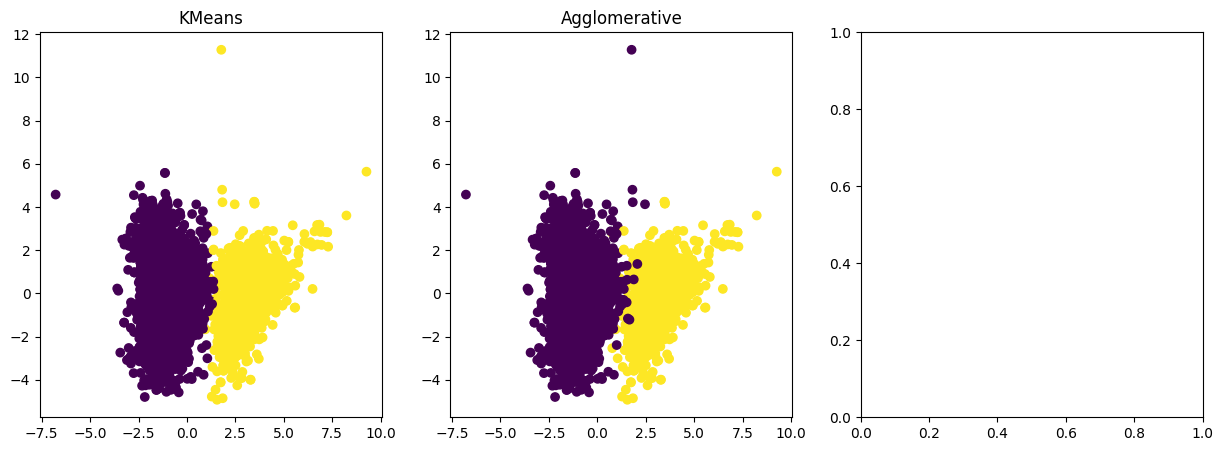

In [3]:
scaler = StandardScaler()
Wine_scaled = scaler.fit_transform(Wine)
Wine = pd.DataFrame(Wine_scaled, columns=Wine.columns)
nClusters = 2
models = []
kmeans = KMeans(n_clusters=nClusters)
kmeans_labels = kmeans.fit_predict(Wine)
models.append({'model': kmeans, 'name': 'KMeans', 'labels': kmeans_labels})
print('Kmeans Silhouette Score:', silhouette_score(Wine, kmeans_labels), "Number of Clusters:", len(np.unique(kmeans_labels)))

agg = AgglomerativeClustering(n_clusters=nClusters)
agg_labels = agg.fit_predict(Wine)
models.append({'model': agg, 'name': 'Agglomerative', 'labels': agg_labels})
print('Agglomerative Silhouette Score:', silhouette_score(Wine, agg_labels), "Number of Clusters:", len(np.unique(agg_labels)))

# visualize the clusters
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(Wine)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()

## Lime

In [37]:
clustterToExplain = 1
i = 100 # instance to explain

#KMeans
y = (kmeans_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(Wine, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(Wine, y)
print('KMeans Accuracy:', accuracy_score(y, clf.predict(Wine)))
explainer = LimeTabularExplainer(Wine.values, mode='classification', feature_names=Wine.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(Wine.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

#Agglomerative
y = (agg_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(Wine, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(Wine, y)
print('Agglomerative Accuracy:', accuracy_score(y, clf.predict(Wine)))
explainer = LimeTabularExplainer(Wine.values, mode='classification', feature_names=Wine.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(Wine.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

KMeans Accuracy: 0.9995382484223487


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Agglomerative Accuracy: 0.9995382484223487


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Decision tree

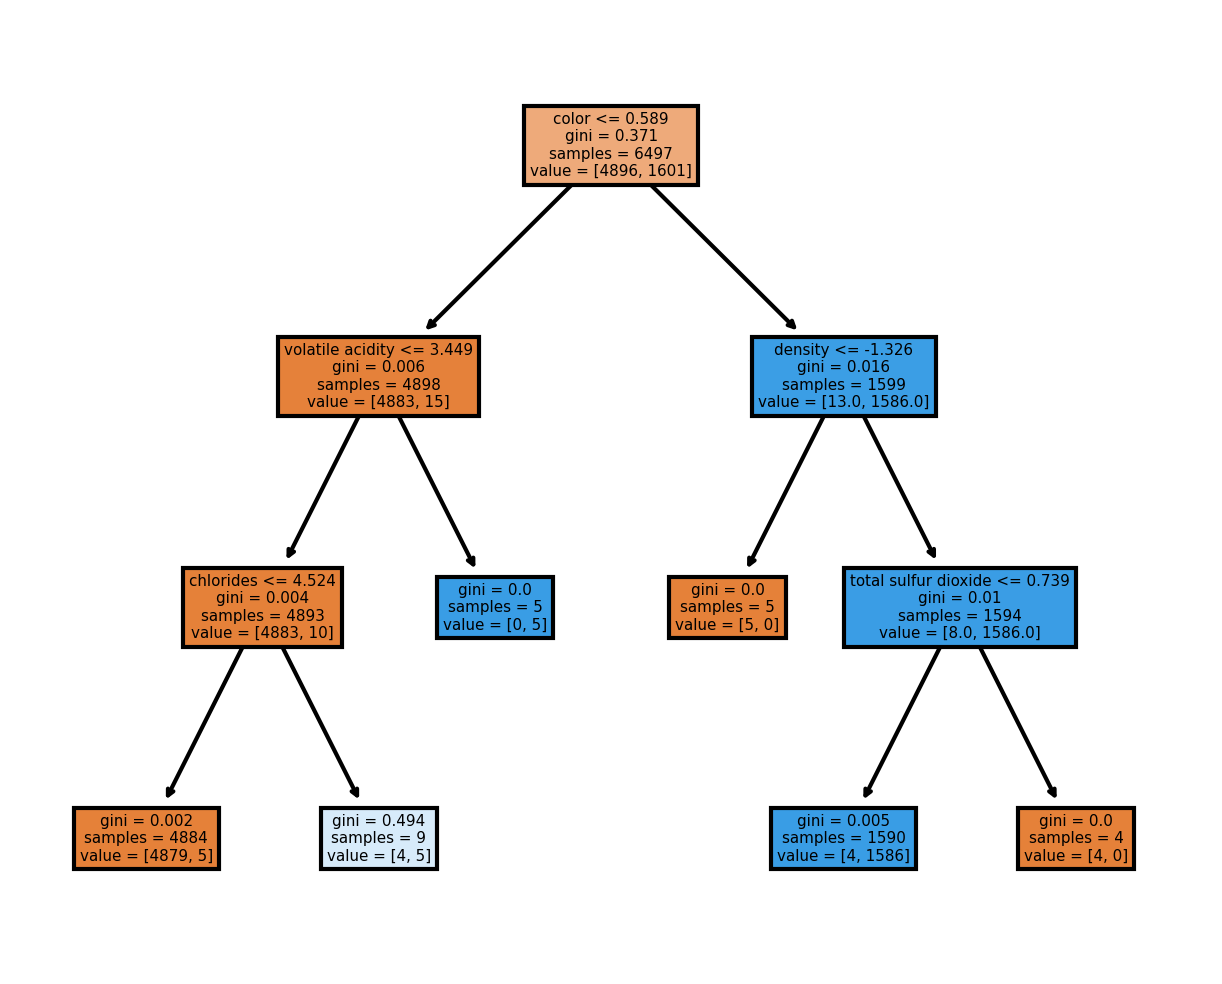

Decision Tree Accuracy: 0.9979990764968447


In [4]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(Wine, kmeans_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=Wine.columns)
plt.show()
y_pred = dt.predict(Wine)
print('Decision Tree Accuracy:', accuracy_score(kmeans_labels, y_pred))


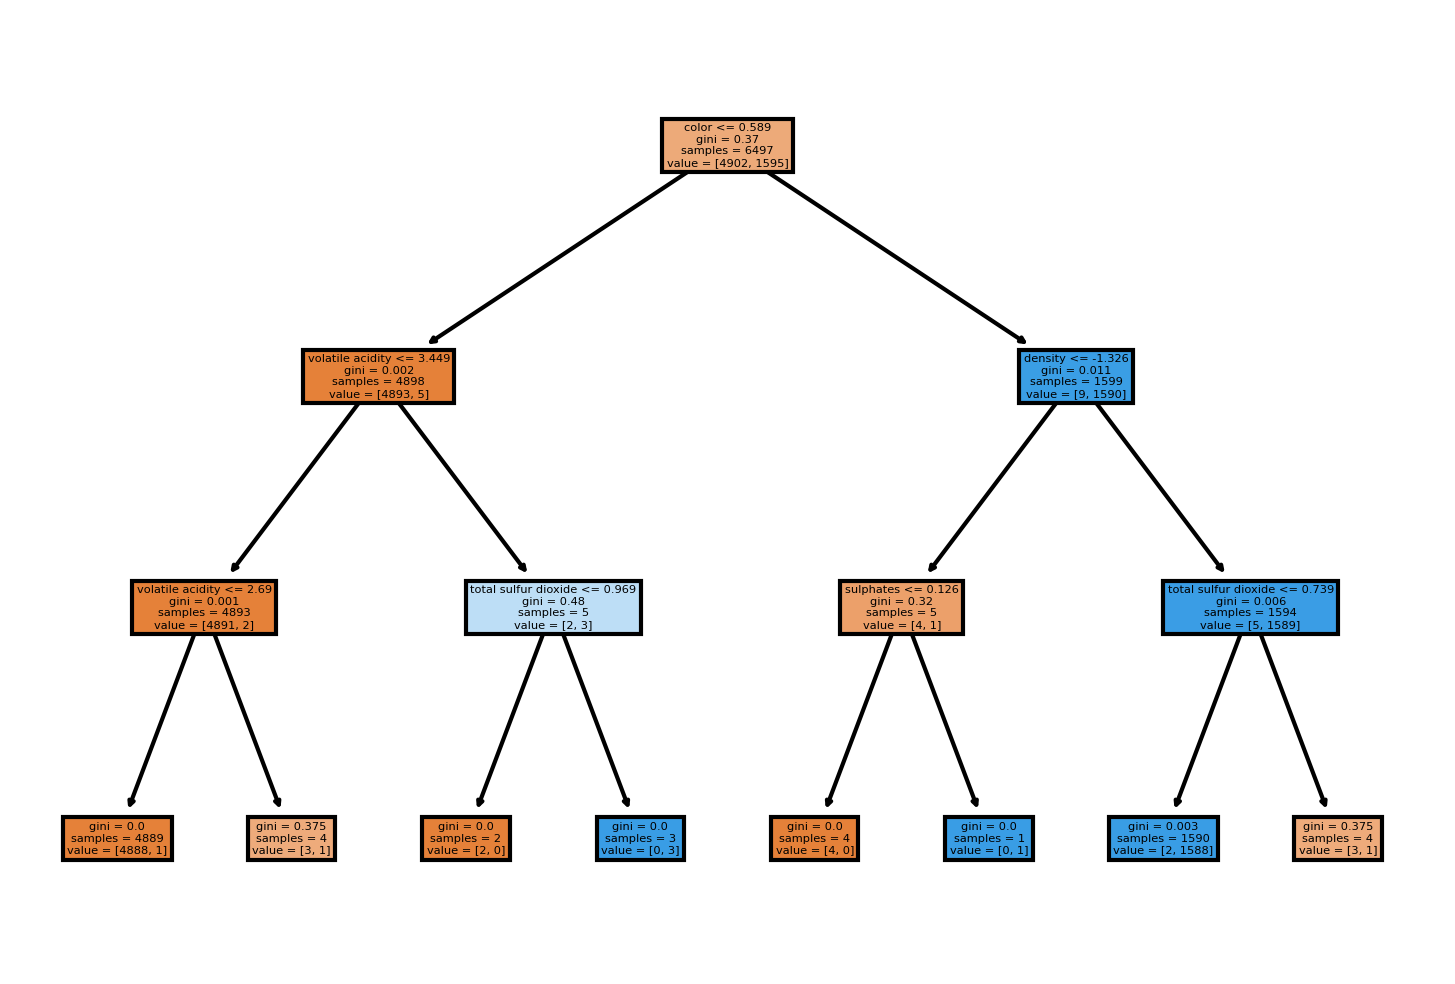

Decision Tree Accuracy: 0.999230414037248


In [6]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(Wine, agg_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=Wine.columns)
plt.show()
y_pred = dt.predict(Wine)
print('Decision Tree Accuracy:', accuracy_score(agg_labels, y_pred))

# RIPPER

In [44]:
pos = 0
# cambiamos las etiquetas para que el positivo sea el cluster 0
kmeans_labels_pos = (kmeans_labels == pos).astype(int)
agg_labels_pos = (agg_labels == pos).astype(int)
# KMeans
ripper = lw.RIPPER()
df = pd.concat([Wine, pd.DataFrame(kmeans_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(Wine)
print('RIPPER Accuracy KMeans:', accuracy_score(kmeans_labels_pos, y_pred))
# Agglomerative
ripper = lw.RIPPER()
df = pd.concat([Wine, pd.DataFrame(agg_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(Wine)
print('RIPPER Accuracy Agglomerative:', accuracy_score(agg_labels_pos, y_pred))

[[color=1.750189840502631^quality=-0.9372296142305016] V [color=1.750189840502631^totalsulfurdioxide=<-1.52] V [color=1.750189840502631^totalsulfurdioxide=-1.52--0.95] V [color=1.750189840502631^totalsulfurdioxide=-0.95--0.47] V [color=1.750189840502631^volatileacidity=0.67-1.52] V [volatileacidity=>1.52^color=1.750189840502631] V [volatileacidity=>1.52^quality=-2.082458277697789^fixedacidity=>1.22] V [color=1.750189840502631^sulphates=0.059-0.33] V [chlorides=>0.86^sulphates=>1.27] V [volatileacidity=>1.52^citricacid=-1.23--0.61^alcohol=>1.52] V [chlorides=>0.86^totalsulfurdioxide=0.29-0.57^fixedacidity=-0.17--0.012]]
RIPPER Accuracy KMeans: 0.9983069108819456
[[color=-0.571366589416845^quality=-0.9372296142305016] V [color=-0.571366589416845^quality=0.20799904923678578] V [color=-0.571366589416845^good=2.0218074982317256] V [color=-0.571366589416845] V [freesulfurdioxide=0.14-0.42^chlorides=-0.26--0.14] V [residualsugar=>1.59^fixedacidity=<-0.94] V [chlorides=<-0.71] V [chlorides=-0.

## DSClustering

Optimization started
Processing epoch	373	0.0006	
Training time: 583.37s, epochs: 400

Least training loss reached: 0.001


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CD-SGD Silhouette Score: 0.29771846412168196 Number of Clusters: 2


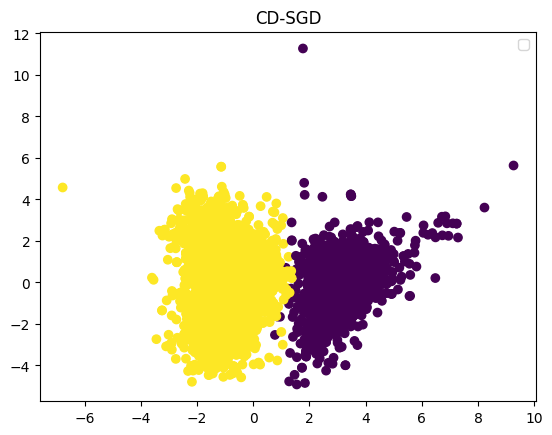

In [41]:
cdsgd = DSClustering(data=Wine,cluster=2)
cdsgd.generate_categorical_rules()
cdsgd_labels = cdsgd.predict()
models.append({'model': cdsgd, 'name': 'CD-SGD con 2 clusters', 'labels': cdsgd_labels})
print('CD-SGD Silhouette Score:', silhouette_score(Wine, cdsgd_labels), "Number of Clusters:", len(np.unique(cdsgd_labels)))
#vvisualize the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Wine)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cdsgd_labels, cmap='viridis')
plt.title('CD-SGD')
plt.legend()
plt.show()

In [42]:
cdsgd.print_most_important_rules()



Most important rules for Cluster 0

	[0.466] R7: fixed acidity > 0.642
			0: 0.466	1: 0.000	Unc: 0.534

	[0.439] R43: sulphates > 0.650
			0: 0.439	1: 0.000	Unc: 0.561

	[0.429] R39: pH > 0.671
			0: 0.429	1: 0.000	Unc: 0.571

	[0.376] R28: total sulfur dioxide < -0.665
			0: 0.376	1: 0.000	Unc: 0.624

	[0.350] R24: free sulfur dioxide < -0.661
			0: 0.350	1: 0.000	Unc: 0.650

	[0.311] R11: volatile acidity > 0.639
			0: 0.311	1: 0.000	Unc: 0.689

	[0.279] R23: chlorides > 0.568
			0: 0.279	1: 0.000	Unc: 0.721

	[0.271] R16: residual sugar < -0.677
			0: 0.271	1: 0.000	Unc: 0.729

	[0.253] R35: density > 0.673
			0: 0.253	1: 0.000	Unc: 0.747

	[0.228] R271: Negative pH - 0.006, good - -0.004
			0: 0.228	1: 0.000	Unc: 0.772

	[0.226] R17: -0.677 < residual sugar < 0.000
			0: 0.222	1: 0.008	Unc: 0.770

	[0.219] R66: Positive fixed acidity - -0.010, citric acid - 0.008
			0: 0.219	1: 0.000	Unc: 0.781

	[0.200] R34: 0.001 < density < 0.673
			0: 0.198	1: 0.006	Unc: 0.797

Most important

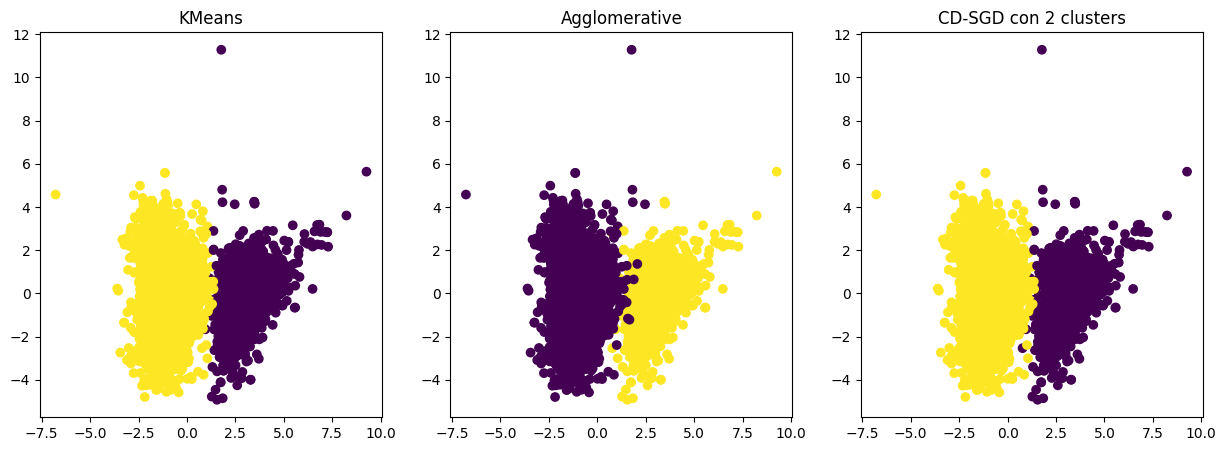

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(Wine)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()